<a href="https://colab.research.google.com/github/billycemerson/PROJECT/blob/main/Analisis_Sentimen_M_Pajak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analisis dan Prediksi Sentimen Ulasan Pengguna Aplikasi M-Pajak di Google Play Store dengan Model Bidirectional LSTM

Biliarto Sastro Cemerson

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## SCRAPING DATA

In [ ]:
!pip install google-play-scraper

In [ ]:
from google_play_scraper import Sort, reviews
import pandas as pd

In [ ]:
# Fungsi untuk mengumpulkan ulasan
def collect_reviews(app_id, count):
    result, _ = reviews(
        app_id,
        lang='id', # bahasa Indonesia
        country='id', # Indonesia
        sort=Sort.NEWEST, # urutkan berdasarkan yang terbaru
        count=count # jumlah ulasan yang ingin dikumpulkan
    )
    return result

app_id = 'id.go.pajak.djp'
reviews_data = collect_reviews(app_id, 5000)

# Konversi hasil ke DataFrame
reviews_df = pd.DataFrame(reviews_data)
reviews_df = reviews_df[['content', 'score']]

In [ ]:
reviews_df.head()

,content,score
0,Sistem nya GK praktis payah padahal mo bayar p...,1
1,Knpa aplikasi djp sekarang sudah masuk,2
2,Masak mau login nggk bisa,1
3,Ada yang punya solusi gk pas mau minta efin ma...,5
4,App sempak banyak bug tapi ga di fix problem,1


In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3166 entries, 0 to 3165
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  3166 non-null   object
 1   score    3166 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 49.6+ KB


In [ ]:
# Simpan hasil ke CSV
reviews_df.to_csv('/content/drive/MyDrive/JST/m-pajak_reviews.csv', index=False)

In [ ]:
#Load data
reviews_df = pd.read_csv('/content/drive/MyDrive/JST/m-pajak_reviews.csv')
reviews_df.head()

,content,score
0,Sistem nya GK praktis payah padahal mo bayar p...,1
1,Knpa aplikasi djp sekarang sudah masuk,2
2,Masak mau login nggk bisa,1
3,Ada yang punya solusi gk pas mau minta efin ma...,5
4,App sempak banyak bug tapi ga di fix problem,1


## EDA

In [ ]:
reviews_df['score'].value_counts()

score
1    2144
5     680
2     149
3     115
4      78
Name: count, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

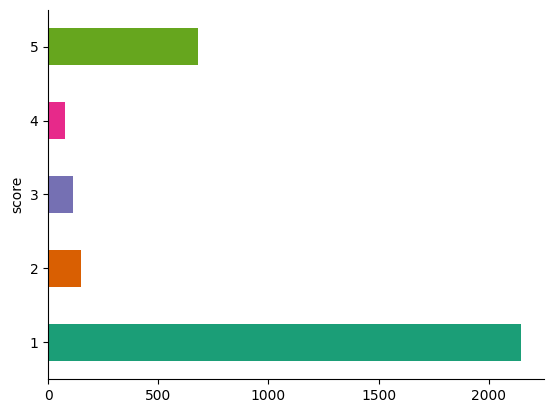

In [ ]:
reviews_df.groupby('score').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## LABELING

In [ ]:
def categorize_sentiment(score):
  if score >= 3:
    return 'Positif'
  else:
    return 'Negatif'

In [ ]:
reviews_df['label'] = reviews_df['score'].apply(categorize_sentiment)
reviews_df.head()

,content,score,label
0,Sistem nya GK praktis payah padahal mo bayar p...,1,Negatif
1,Knpa aplikasi djp sekarang sudah masuk,2,Negatif
2,Masak mau login nggk bisa,1,Negatif
3,Ada yang punya solusi gk pas mau minta efin ma...,5,Positif
4,App sempak banyak bug tapi ga di fix problem,1,Negatif


In [ ]:
reviews_df['label'].value_counts()

label
Negatif    2293
Positif     873
Name: count, dtype: int64

In [ ]:
data = reviews_df[['content', 'label']]
data.rename(columns={'content': 'review'}, inplace=True)
data.head()

<ipython-input-15-bd1d6636ad78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'content': 'review'}, inplace=True)


,review,label
0,Sistem nya GK praktis payah padahal mo bayar p...,Negatif
1,Knpa aplikasi djp sekarang sudah masuk,Negatif
2,Masak mau login nggk bisa,Negatif
3,Ada yang punya solusi gk pas mau minta efin ma...,Positif
4,App sempak banyak bug tapi ga di fix problem,Negatif


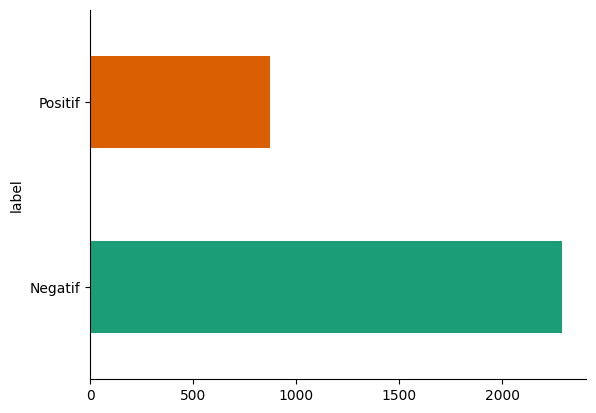

In [ ]:
data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
data.groupby('label').size()

label
Negatif    2293
Positif     873
dtype: int64

## PRAPROSES DATA

In [ ]:
!pip install emoji --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.9 MB/s eta 0:00:00


In [ ]:
!pip install nltk Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.3 MB/s eta 0:00:00


In [ ]:
import re
import nltk
import emoji
import string
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import sent_tokenize, word_tokenize

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data['review'].head()

0    Sistem nya GK praktis payah padahal mo bayar p...
1               Knpa aplikasi djp sekarang sudah masuk
2                            Masak mau login nggk bisa
3    Ada yang punya solusi gk pas mau minta efin ma...
4         App sempak banyak bug tapi ga di fix problem
Name: review, dtype: object

#### Casefolding

In [ ]:
data['casefolding'] = data['review'].str.lower()

In [ ]:
data['casefolding'].head()

0    sistem nya gk praktis payah padahal mo bayar p...
1               knpa aplikasi djp sekarang sudah masuk
2                            masak mau login nggk bisa
3    ada yang punya solusi gk pas mau minta efin ma...
4         app sempak banyak bug tapi ga di fix problem
Name: casefolding, dtype: object

#### Cleaning

In [ ]:
def cleaning(text):
    # remove emoji
    text = ''.join(c for c in text if c not in emoji.EMOJI_DATA)
    # remove link
    text = re.sub(r'http\S+', '', text)
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # remove newline
    text = text.replace('\n', ' ')
    return text

In [ ]:
data['cleaning'] = data['casefolding'].apply(cleaning)

In [ ]:
data['cleaning'].head()

0    sistem nya gk praktis payah padahal mo bayar p...
1               knpa aplikasi djp sekarang sudah masuk
2                            masak mau login nggk bisa
3    ada yang punya solusi gk pas mau minta efin ma...
4         app sempak banyak bug tapi ga di fix problem
Name: cleaning, dtype: object

#### Tokenizeng

In [ ]:
data['tokenizing'] = data['cleaning'].apply(word_tokenize)

In [ ]:
data['tokenizing'].head()

0    [sistem, nya, gk, praktis, payah, padahal, mo,...
1        [knpa, aplikasi, djp, sekarang, sudah, masuk]
2                      [masak, mau, login, nggk, bisa]
3    [ada, yang, punya, solusi, gk, pas, mau, minta...
4    [app, sempak, banyak, bug, tapi, ga, di, fix, ...
Name: tokenizing, dtype: object

#### Normalization

https://github.com/nasalsabila/kamus-alay/blob/master/colloquial-indonesian-lexicon.csv

In [ ]:
kamus = pd.read_csv('/content/drive/MyDrive/JST/Kamus/Kamus Normalisasi.csv')
kamus.head()

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0


In [ ]:
def normalisasi(token):
  for i in range(len(token)):
    if token[i] in kamus['slang'].values:
      idx = kamus.index[kamus['slang'] == token[i]][0]
      token[i] = kamus['formal'][idx]
  return token

In [ ]:
data['normalization'] = data['tokenizing'].apply(normalisasi)
data['normalization'].head()

0    [sistem, nya, enggak, praktis, payah, padahal,...
1      [kenapa, aplikasi, djp, sekarang, sudah, masuk]
2                    [masak, mau, login, enggak, bisa]
3    [ada, yang, punya, solusi, enggak, pas, mau, m...
4    [app, sempak, banyak, bug, tapi, enggak, di, f...
Name: normalization, dtype: object

#### Stopword Removal

In [ ]:
from nltk.corpus import stopwords

In [ ]:
# Fungsi Stopword Removal dengan pengecualian kata 'tidak'
list_stopwords = set(stopwords.words('indonesian')) - {'tidak'}

In [ ]:
list_dialects = set(list_stopwords)

def stopwords_removal(words):
  return [word for word in words if word not in list_stopwords]

data['stopword'] = data['normalization'].apply(stopwords_removal)

In [ ]:
data['stopword'].head()

0    [sistem, nya, praktis, payah, bayar, pajak, ak...
1                               [aplikasi, djp, masuk]
2                                       [masak, login]
3    [solusi, pas, efin, memasukkan, kode, otp, err...
4                     [app, sempak, bug, fix, problem]
Name: stopword, dtype: object

#### Stemming

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmed_wrapper(term):
  return stemmer.stem(term)

In [ ]:
data['stemming'] = data['stopword'].apply(lambda x: [stemmer.stem(y) for y in x if isinstance(y, str)])

#### Text Clean

In [ ]:
data['text_clean'] = data['stemming'].apply(lambda x: ' '.join(map(str, x)))

In [ ]:
data['text_clean'].head()

0    sistem nya praktis payah bayar pajak akses mas...
1                                   aplikasi djp masuk
2                                          masak login
3    solusi pas efin masuk kode otp error ya kantor...
4                           app sempak bug fix problem
Name: text_clean, dtype: object

In [ ]:
data[['text_clean', 'label']].to_csv('/content/drive/MyDrive/JST/Data Modelling.csv', index=False)

## Modelling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/JST/Data Modelling.csv')
data.head()

,text_clean,label
0,sistem nya praktis payah bayar pajak akses mas...,Negatif
1,aplikasi djp masuk,Negatif
2,masak login,Negatif
3,solusi pas efin masuk kode otp error ya kantor...,Positif
4,app sempak bug fix problem,Negatif


In [ ]:
data.dropna(subset=['text_clean'], inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3107 entries, 0 to 3165
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text_clean  3107 non-null   object
 1   label       3107 non-null   object
dtypes: object(2)
memory usage: 72.8+ KB


#### Encoding Label

In [ ]:
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])

#### Split Data

In [ ]:
data['label_encoded'].value_counts()

label_encoded
0    2276
1     831
Name: count, dtype: int64

In [ ]:
X = data['text_clean']
y = data['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_train.value_counts()

label_encoded
0    1800
1     685
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

label_encoded
0    476
1    146
Name: count, dtype: int64

#### Tokenization and Padding

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
max_len = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

#### Oversampling Using SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_padded, y_train)

In [ ]:
y_train_resampled.value_counts()

label_encoded
0    1800
1    1800
Name: count, dtype: int64

#### Model LSTM

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 58, 128)           640000    
                                                                 
 spatial_dropout1d (Spatial  (None, 58, 128)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 58, 200)           183200    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               240800    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                        

In [ ]:
history = model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/10
57/57 [==============================] - 78s 1s/step - loss: 0.5609 - accuracy: 0.7022 - val_loss: 0.4502 - val_accuracy: 0.8232
Epoch 2/10
57/57 [==============================] - 53s 933ms/step - loss: 0.4075 - accuracy: 0.8156 - val_loss: 0.4254 - val_accuracy: 0.8280
Epoch 3/10
57/57 [==============================] - 52s 907ms/step - loss: 0.3449 - accuracy: 0.8567 - val_loss: 0.3766 - val_accuracy: 0.8489
Epoch 4/10
57/57 [==============================] - 61s 1s/step - loss: 0.3041 - accuracy: 0.8806 - val_loss: 0.4016 - val_accuracy: 0.8392
Epoch 5/10
57/57 [==============================] - 49s 859ms/step - loss: 0.2691 - accuracy: 0.8947 - val_loss: 0.4281 - val_accuracy: 0.8248
Epoch 6/10
57/57 [==============================] - 54s 951ms/step - loss: 0.2423 - accuracy: 0.9053 - val_loss: 0.3945 - val_accuracy: 0.8489
Epoch 7/10
57/57 [==============================] - 51s 889ms/step - loss: 0.2184 - accuracy: 0.9153 - val_loss: 0.4743 - val_accuracy: 0.8151
Epoch

#### Evaluation Model

In [ ]:
y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5).astype(int)

19/19 [==============================] - 3s 84ms/step


In [ ]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

     Negatif       0.94      0.83      0.88       447
     Positif       0.63      0.84      0.72       148

    accuracy                           0.84       595
   macro avg       0.79      0.84      0.80       595
weighted avg       0.86      0.84      0.84       595



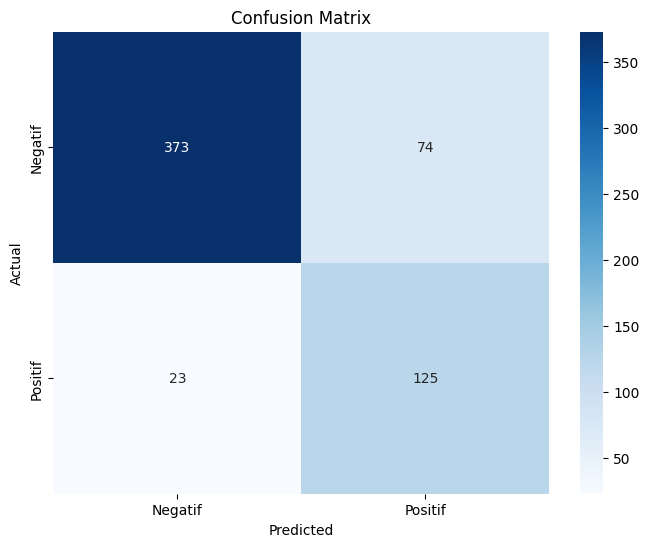

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

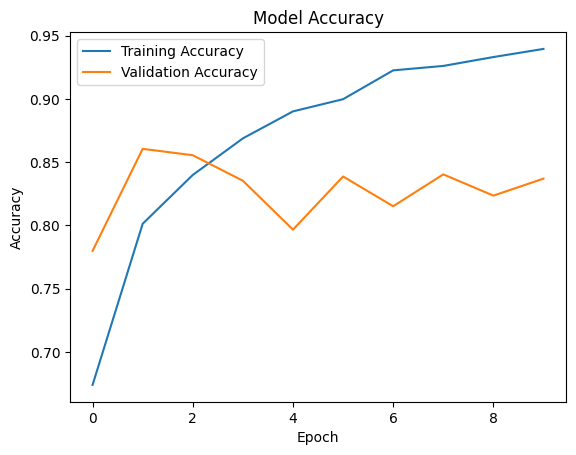

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

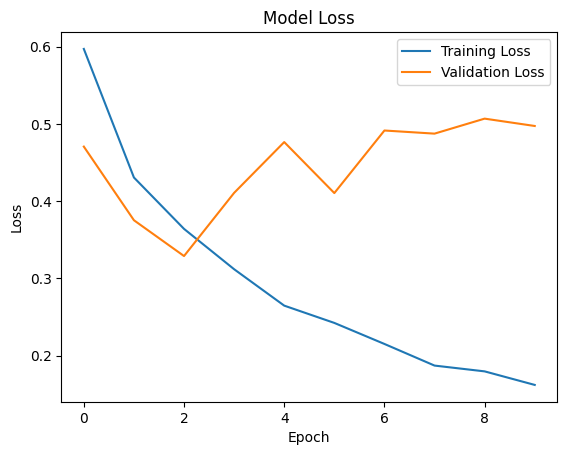

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()